In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib import gridspec
from uncertainties import ufloat
from uncertainties.umath import * 
from uncertainties import unumpy as unp
from scipy.optimize import curve_fit
from scipy.special import factorial

In [2]:
Exp1 = pd.read_excel('../data/Exp1.xlsx')
Exp2 = pd.read_excel('../data/Exp2.xlsx')
Exp3 = pd.read_excel('../data/Exp3.xlsx')
Exp4 = pd.read_excel('../data/Exp4.xlsx')
Bonus = pd.read_excel('../data/Bonus.xlsx')
Back = pd.read_excel('../data/Background.xlsx')
Tech = pd.read_excel('../data/Tech.xlsx')

In [3]:
def cropdf(data, mins):
    lim = mins*60
    return data.loc[(data[data.columns[0]] <= lim)]

In [4]:
Exp1, Exp2, Exp4 = cropdf(Exp1, 5), cropdf(Exp2, 5), cropdf(Exp4, 5)
Exp3 = cropdf(Exp3, 1)
Back1min = cropdf(Back[Back.columns[:2]], 1)
Back5min = cropdf(Back[Back.columns[2:]], 5)

In [5]:
def getcounts(data):
    return data[data.columns[1:len(data.axes[1]):2]]

In [6]:
cExp1, cExp2, cExp3, cExp4, cTech = getcounts(Exp1), getcounts(Exp2), getcounts(Exp3), getcounts(Exp4), getcounts(Tech)
cBack1min, cBack5min = getcounts(Back1min), getcounts(Back5min)
cBonus = getcounts(Bonus) #to get a np matrix just use df.values then each column is a run

In [7]:
cBonus = cBonus[['Bonus 4.95.1', 'Bonus 5.1.1', 'Bonus 5.30.1', 'Bonus 5.9.1', 'Bonus 7.10.1', 'Bonus 8.00.1', 'Bonus 8.90.1', 'Bonus 15.4.1']]
cBonus.head()

,Bonus 4.95.1,Bonus 5.1.1,Bonus 5.30.1,Bonus 5.9.1,Bonus 7.10.1,Bonus 8.00.1,Bonus 8.90.1,Bonus 15.4.1
0,8,4,5,2,1,1,0,0
1,4,6,2,6,1,3,1,0
2,10,3,1,3,2,1,1,1
3,6,5,4,4,1,2,0,0
4,5,8,3,3,3,2,0,1


In [8]:
def calcbins(data, binwidth=1):
    return np.arange(min(data), max(data) + binwidth, binwidth)
def replaceval(data, to_replace=0):
    return data.replace(to_replace, value=np.nan)

In [9]:
cBack1min, cBack5min = replaceval(cBack1min), replaceval(cBack5min)

In [10]:
pd.options.mode.chained_assignment = None  # default='warn'
def addsumdf(data, name, axis=1):
    data[name] = data.sum(axis)
    return data
def addavgdf(data, name, axis=1):
    data[name] = data.sum(axis) / data.shape[1]
    return data

In [11]:
cExp3_vertical = cExp3.sum(axis=0)
cExp1 = addsumdf(cExp1, 'Exp1 Horizontal Sum')
cExp2 = addsumdf(cExp2, 'Exp2 Horizontal Sum')
cExp2 = addavgdf(cExp2, 'Exp2 Horizontal Average')
cExp3 = addsumdf(cExp3, 'Exp3 Horizontal Sum')
cExp4 = addsumdf(cExp4, 'Exp4 Horizontal Sum')

In [12]:
cAllExp = [cExp1, cExp2, cExp3, cExp4, cBonus, cTech, cExp3_vertical]

In [13]:
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))
def poisson_function(x, a, mu):
    return a*(mu**x)*(np.e**(-mu))/(factorial(x))

In [14]:
def errors(pcov): 
    return np.sqrt(np.diag(pcov))
def totalerr(pcov):
    return np.sqrt(sum(x**2 for x in errors(pcov)))

93.38250380629833


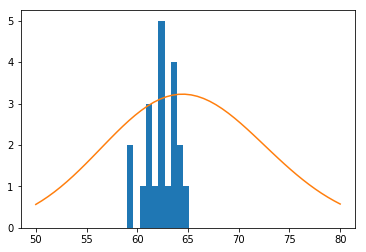

In [15]:
cAllExp_no3 = [cExp3_vertical]

e = cExp3_vertical/20
plt.hist(e)
print(np.std(e)**10)
testerx= np.linspace(50, 80)
plt.plot(testerx, poisson_function(testerx, np.max(e), np.std(e)**9.2))
plt.show()

In [16]:
def extract_and_plot_stuff(run, bgdata, rundata, binwidth, plotGauss=True, plotPoisson=True):
    bg_hist, bins = np.histogram(bgdata, bins=calcbins(rundata, binwidth))
    data_hist, _ = np.histogram(rundata, bins=calcbins(rundata, binwidth))

    plot_hist = data_hist
    for i in np.nonzero(bg_hist)[0]:
        plot_hist[i] = plot_hist[i] - bg_hist[i] if data_hist[i] - bg_hist[i] > 0 else 0

    histx = [0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins)-1)]

    data_mean_guess = rundata.mean()
    data_std_guess = rundata.std()
    data_a_guess = max(plot_hist)
    
    fig, (a0, a1) = plt.subplots(nrows=2, ncols=1, gridspec_kw = {'height_ratios':[3, 1]}, sharex=True, figsize=(6,6))
    fig.subplots_adjust(hspace=.08)
    a0.bar(bins[:-1], plot_hist, width=.8*binwidth, alpha=0.75) 
    xdata = np.linspace(min(bins), max(bins)) #for plotting g and p

#     print(type(plot_hist), type(bins))
    if plotGauss == True:
        gauss_params, gauss_cov = curve_fit(gauss_function,histx,plot_hist,p0=(data_a_guess,data_mean_guess,data_std_guess))
        residuals_gauss = gauss_function(histx, *gauss_params) - plot_hist
        print('Gaussian fit: a=', '%.2f'%gauss_params[0], '+/-', '%.2f'%errors(gauss_cov)[0] ,
              ', x0=', '%.2f'%gauss_params[1], '+/-',  '%.2f'%errors(gauss_cov)[1],
              ', sigma=sqrt(mu)=', '%.2f'%gauss_params[2], '+/-',  '%.2f'%errors(gauss_cov)[2])
        a0.plot(xdata, gauss_function(xdata, *gauss_params), 'r', label='Gaussian Fit')

        k_gauss = totalerr(gauss_cov)
        a1.errorbar(histx, residuals_gauss, yerr = k_gauss, marker='.', color='r', linestyle='None', capsize=3, 
                    label='Gaus.')
    if plotPoisson == True:
        poisson_params, poisson_cov = curve_fit(poisson_function, histx, plot_hist, p0=(data_a_guess, data_std_guess**2))
        residuals_poisson = poisson_function(histx, *poisson_params) - plot_hist
        print('Poisson fit: a=', '%.2f'%poisson_params[0], '+/-', '%.2f'%errors(poisson_cov)[0],
              ', mu=sigma^2=', '%.2f'%poisson_params[1], '+/-', '%.2f'%errors(poisson_cov)[1])

        a0.plot(xdata, poisson_function(xdata, *poisson_params), 'g', label='Poisson Fit')
        k_poisson = totalerr(poisson_cov)
        a1.errorbar(histx, residuals_poisson, yerr=k_poisson, marker='.', color='g', linestyle='None', capsize=3, 
                    label='Pois.')
        
    title = run[:-2] if '.1' in run else run
    a0.set_title(title)
    a0.set_ylabel('Count')
    a1.set_ylabel('Residuals')
    if plotGauss or plotPoisson: a0.legend(); a1.legend(loc='upper right')
#     SAVEFIG STUFF
    plt.show()
    
    if plotGauss and plotPoisson: 
        return (gauss_params, gauss_cov), (poisson_params, poisson_cov)
    elif plotGauss:
        return (gauss_params, gauss_cov)
    elif plotPoisson:
        return (poisson_params, poisson_cov)

In [17]:
fitting_out = [[] for x in range(len(cAllExp))]

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 339.97 +/- 10.88 , x0= 3.67 +/- 0.06 , sigma=sqrt(mu)= 1.66 +/- 0.06
Poisson fit: a= 1522.15 +/- 73.94 , mu=sigma^2= 3.93 +/- 0.13


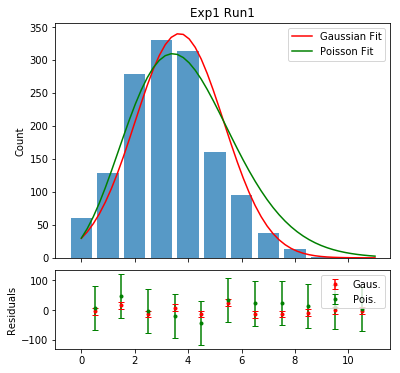

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 334.82 +/- 15.85 , x0= 3.69 +/- 0.09 , sigma=sqrt(mu)= 1.71 +/- 0.10
Poisson fit: a= 1524.04 +/- 77.84 , mu=sigma^2= 3.95 +/- 0.14


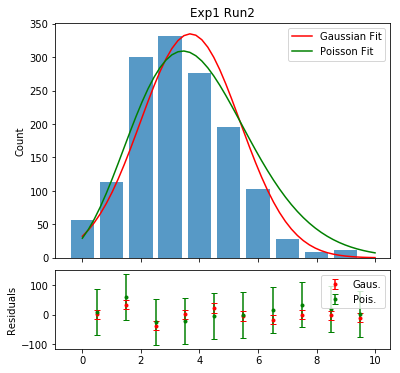

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 354.15 +/- 18.98 , x0= 3.56 +/- 0.10 , sigma=sqrt(mu)= 1.58 +/- 0.10
Poisson fit: a= 1532.52 +/- 98.02 , mu=sigma^2= 3.84 +/- 0.17


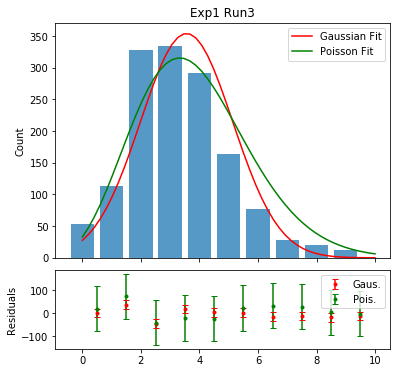

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 198.94 +/- 4.97 , x0= 9.94 +/- 0.09 , sigma=sqrt(mu)= 2.96 +/- 0.09
Poisson fit: a= 1528.46 +/- 30.05 , mu=sigma^2= 10.20 +/- 0.09


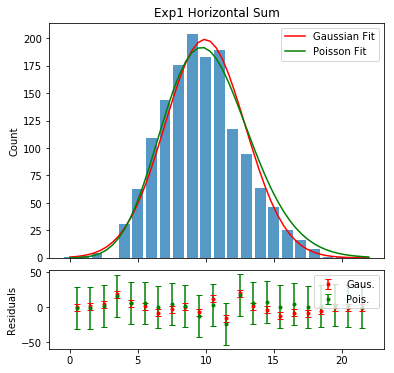

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 9.24 +/- 0.91 , x0= 41.88 +/- 0.74 , sigma=sqrt(mu)= 6.52 +/- 0.76
Poisson fit: a= 150.19 +/- 11.99 , mu=sigma^2= 42.15 +/- 0.73


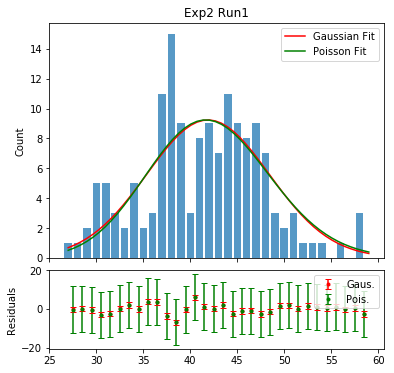

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 9.17 +/- 0.60 , x0= 42.00 +/- 0.50 , sigma=sqrt(mu)= 6.69 +/- 0.53
Poisson fit: a= 151.34 +/- 7.96 , mu=sigma^2= 42.28 +/- 0.49


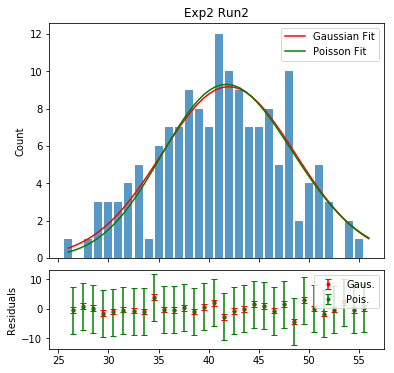

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 8.90 +/- 0.67 , x0= 41.13 +/- 0.58 , sigma=sqrt(mu)= 6.74 +/- 0.60
Poisson fit: a= 146.75 +/- 8.82 , mu=sigma^2= 41.38 +/- 0.55


C:\Users\Home\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


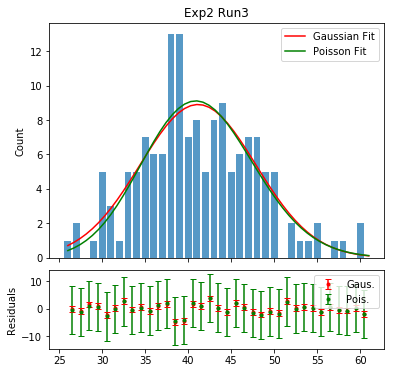

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 4.63 +/- 0.42 , x0= 123.87 +/- 1.39 , sigma=sqrt(mu)= 13.26 +/- 1.42


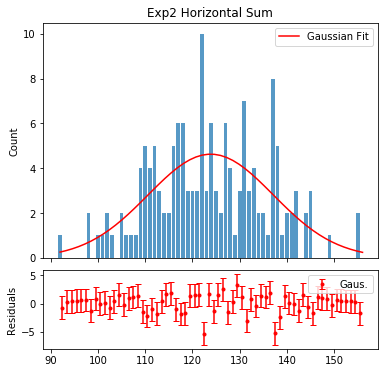

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 9.30 +/- 0.72 , x0= 61.97 +/- 0.59 , sigma=sqrt(mu)= 6.59 +/- 0.60
Poisson fit: a= 167.11 +/- 11.08 , mu=sigma^2= 62.26 +/- 0.75


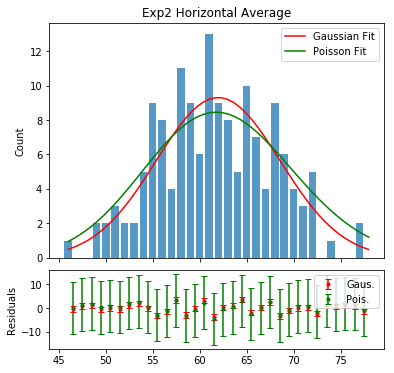

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 168.99 +/- 6.70 , x0= 2.32 +/- 0.07 , sigma=sqrt(mu)= 1.40 +/- 0.07
Poisson fit: a= 625.52 +/- 29.62 , mu=sigma^2= 2.60 +/- 0.11


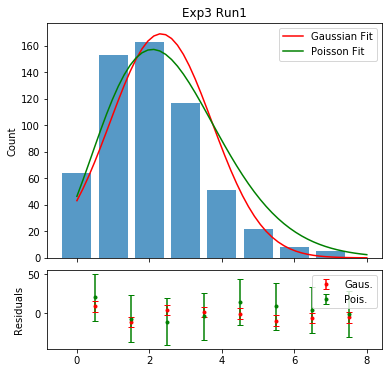

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 159.36 +/- 3.75 , x0= 2.16 +/- 0.05 , sigma=sqrt(mu)= 1.56 +/- 0.05
Poisson fit: a= 611.52 +/- 16.20 , mu=sigma^2= 2.47 +/- 0.06


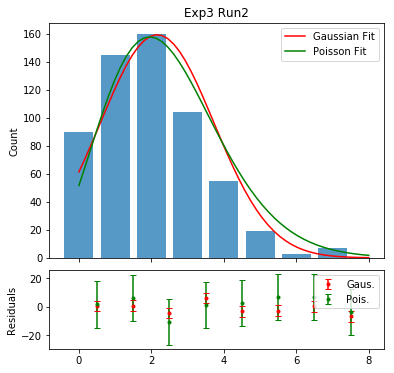

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 147.30 +/- 5.15 , x0= 2.30 +/- 0.08 , sigma=sqrt(mu)= 1.73 +/- 0.09
Poisson fit: a= 604.02 +/- 6.56 , mu=sigma^2= 2.63 +/- 0.02


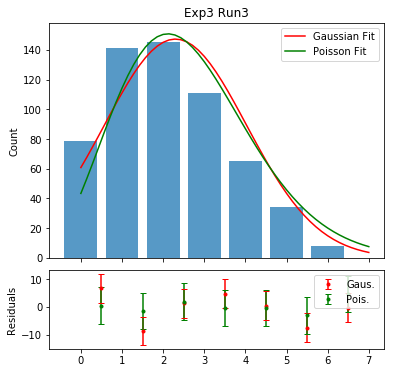

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 156.07 +/- 5.12 , x0= 2.26 +/- 0.06 , sigma=sqrt(mu)= 1.59 +/- 0.07
Poisson fit: a= 610.46 +/- 21.31 , mu=sigma^2= 2.57 +/- 0.08


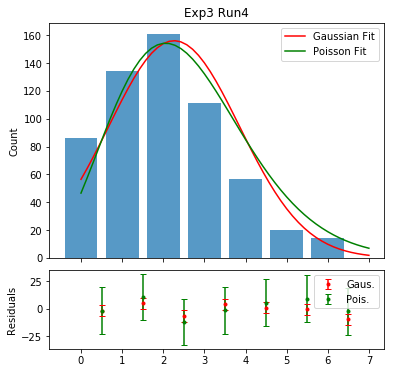

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 146.22 +/- 2.63 , x0= 2.30 +/- 0.04 , sigma=sqrt(mu)= 1.72 +/- 0.04
Poisson fit: a= 598.21 +/- 6.11 , mu=sigma^2= 2.63 +/- 0.02


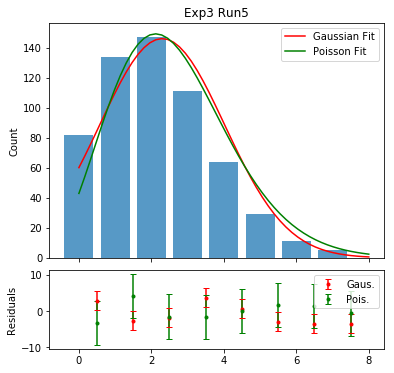

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 162.29 +/- 8.71 , x0= 2.33 +/- 0.09 , sigma=sqrt(mu)= 1.45 +/- 0.10
Poisson fit: a= 612.96 +/- 30.03 , mu=sigma^2= 2.63 +/- 0.11


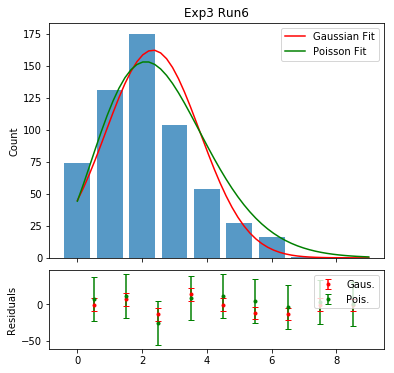

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 157.62 +/- 5.62 , x0= 2.27 +/- 0.07 , sigma=sqrt(mu)= 1.56 +/- 0.08
Poisson fit: a= 612.58 +/- 13.97 , mu=sigma^2= 2.57 +/- 0.05


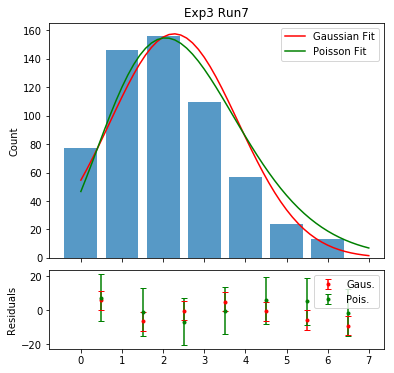

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 161.22 +/- 10.28 , x0= 2.34 +/- 0.11 , sigma=sqrt(mu)= 1.49 +/- 0.12
Poisson fit: a= 616.15 +/- 37.15 , mu=sigma^2= 2.63 +/- 0.14


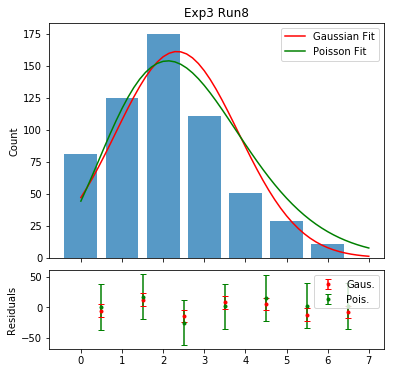

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 162.60 +/- 4.17 , x0= 2.46 +/- 0.04 , sigma=sqrt(mu)= 1.48 +/- 0.05
Poisson fit: a= 625.87 +/- 27.84 , mu=sigma^2= 2.73 +/- 0.10


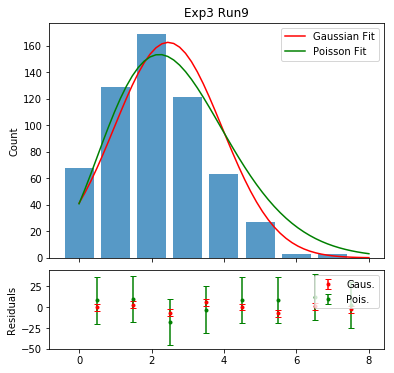

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 150.54 +/- 7.46 , x0= 2.23 +/- 0.10 , sigma=sqrt(mu)= 1.64 +/- 0.11
Poisson fit: a= 599.24 +/- 16.17 , mu=sigma^2= 2.57 +/- 0.06


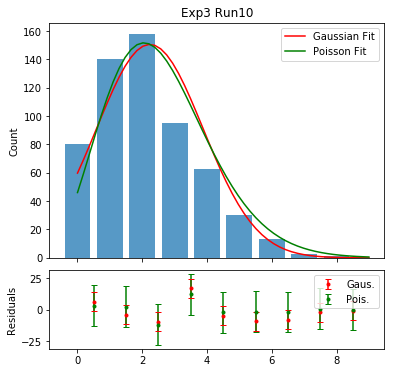

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 158.04 +/- 10.95 , x0= 2.41 +/- 0.13 , sigma=sqrt(mu)= 1.54 +/- 0.14
Poisson fit: a= 618.48 +/- 35.44 , mu=sigma^2= 2.71 +/- 0.13


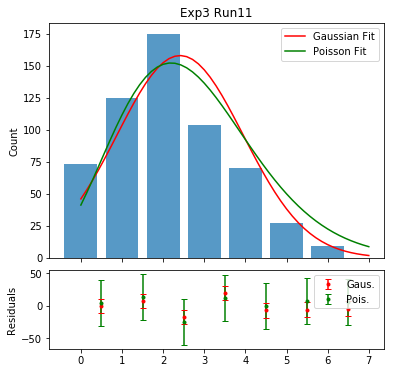

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 161.77 +/- 7.08 , x0= 2.31 +/- 0.08 , sigma=sqrt(mu)= 1.50 +/- 0.09
Poisson fit: a= 619.19 +/- 21.80 , mu=sigma^2= 2.61 +/- 0.08


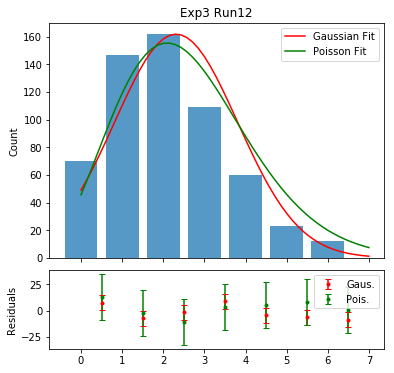

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 161.68 +/- 7.27 , x0= 2.21 +/- 0.08 , sigma=sqrt(mu)= 1.51 +/- 0.09
Poisson fit: a= 614.75 +/- 18.55 , mu=sigma^2= 2.51 +/- 0.07


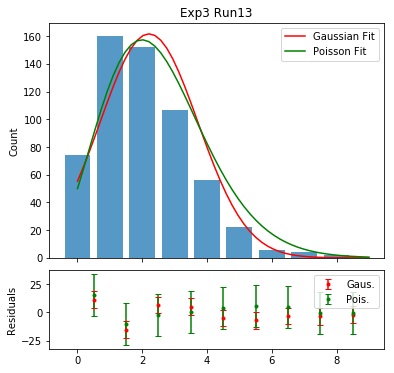

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 173.55 +/- 10.29 , x0= 2.39 +/- 0.09 , sigma=sqrt(mu)= 1.34 +/- 0.10
Poisson fit: a= 629.52 +/- 48.06 , mu=sigma^2= 2.66 +/- 0.17


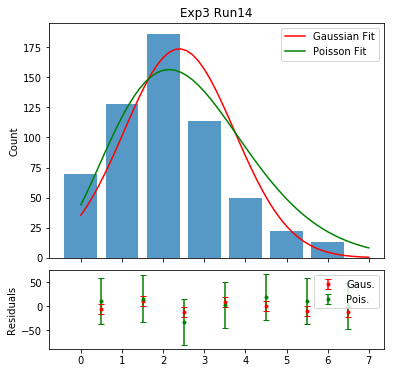

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 160.22 +/- 7.28 , x0= 2.42 +/- 0.08 , sigma=sqrt(mu)= 1.50 +/- 0.09
Poisson fit: a= 619.97 +/- 28.41 , mu=sigma^2= 2.71 +/- 0.11


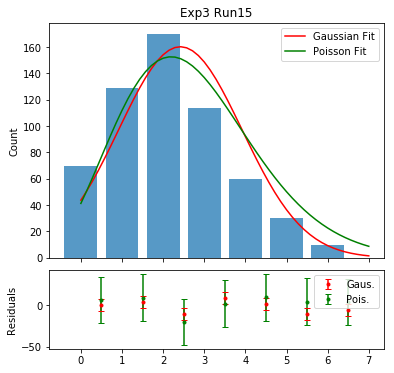

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 162.51 +/- 3.37 , x0= 2.56 +/- 0.04 , sigma=sqrt(mu)= 1.48 +/- 0.04
Poisson fit: a= 628.35 +/- 34.27 , mu=sigma^2= 2.81 +/- 0.13


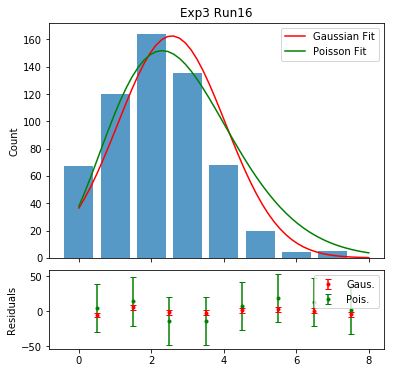

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 163.02 +/- 7.49 , x0= 2.24 +/- 0.08 , sigma=sqrt(mu)= 1.50 +/- 0.09
Poisson fit: a= 620.16 +/- 24.00 , mu=sigma^2= 2.54 +/- 0.09


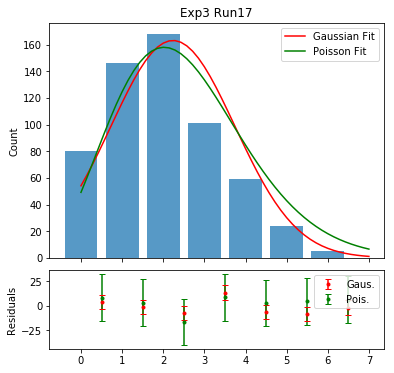

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 159.22 +/- 7.38 , x0= 2.21 +/- 0.09 , sigma=sqrt(mu)= 1.52 +/- 0.10
Poisson fit: a= 608.28 +/- 20.30 , mu=sigma^2= 2.52 +/- 0.07


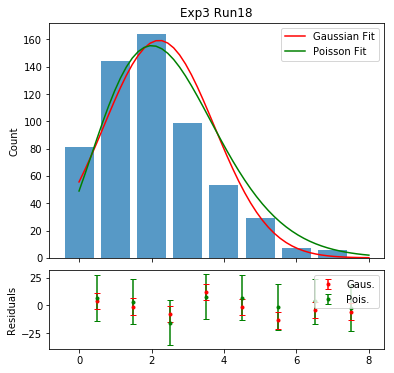

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 164.33 +/- 5.45 , x0= 2.24 +/- 0.06 , sigma=sqrt(mu)= 1.47 +/- 0.06
Poisson fit: a= 617.11 +/- 22.96 , mu=sigma^2= 2.54 +/- 0.08


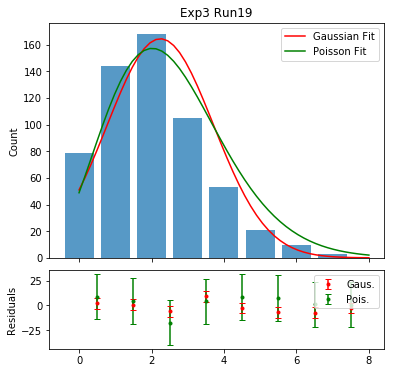

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 156.51 +/- 4.10 , x0= 2.31 +/- 0.05 , sigma=sqrt(mu)= 1.56 +/- 0.05
Poisson fit: a= 609.86 +/- 19.70 , mu=sigma^2= 2.61 +/- 0.07


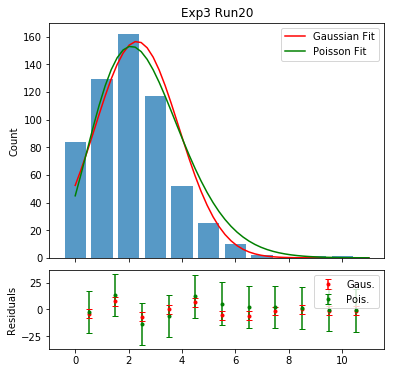

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 36.78 +/- 1.05 , x0= 41.53 +/- 0.22 , sigma=sqrt(mu)= 6.56 +/- 0.22
Poisson fit: a= 600.18 +/- 13.38 , mu=sigma^2= 41.77 +/- 0.20


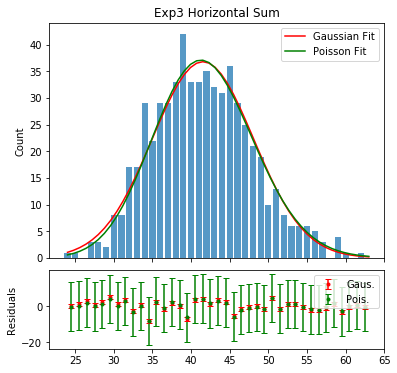

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 24.28 +/- 1.94 , x0= 6.76 +/- 0.22 , sigma=sqrt(mu)= 2.39 +/- 0.22
Poisson fit: a= 152.68 +/- 9.16 , mu=sigma^2= 7.03 +/- 0.22


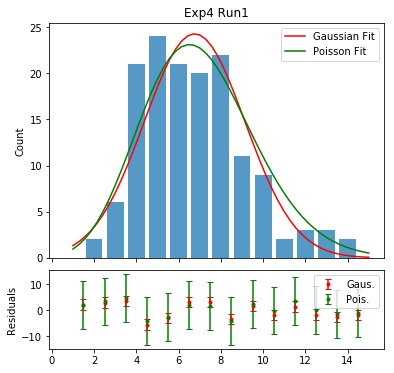

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 25.26 +/- 0.97 , x0= 7.45 +/- 0.10 , sigma=sqrt(mu)= 2.32 +/- 0.10
Poisson fit: a= 158.75 +/- 7.60 , mu=sigma^2= 7.69 +/- 0.19


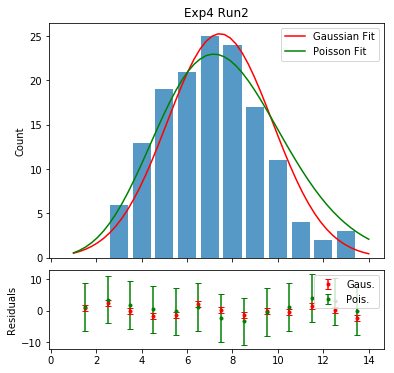

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 23.04 +/- 1.54 , x0= 7.60 +/- 0.20 , sigma=sqrt(mu)= 2.61 +/- 0.21
Poisson fit: a= 154.92 +/- 8.97 , mu=sigma^2= 7.82 +/- 0.23


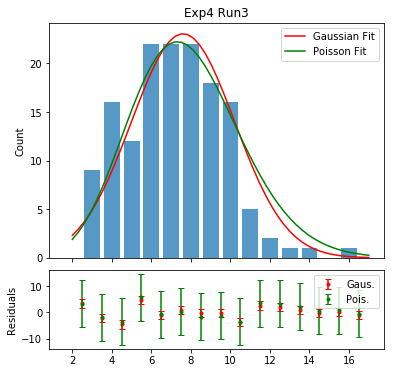

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 21.64 +/- 1.80 , x0= 7.34 +/- 0.27 , sigma=sqrt(mu)= 2.78 +/- 0.27
Poisson fit: a= 150.17 +/- 8.42 , mu=sigma^2= 7.58 +/- 0.22


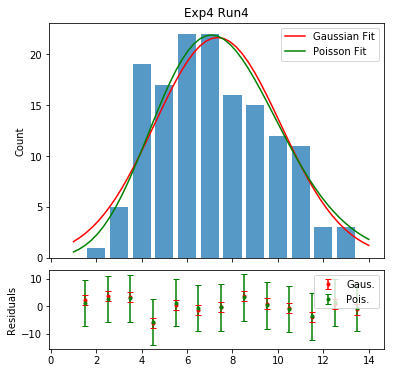

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 23.94 +/- 1.59 , x0= 7.47 +/- 0.19 , sigma=sqrt(mu)= 2.44 +/- 0.19
Poisson fit: a= 155.12 +/- 8.90 , mu=sigma^2= 7.72 +/- 0.23


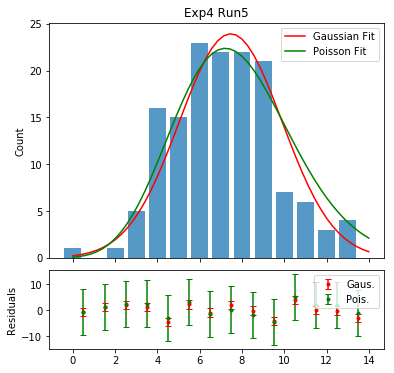

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 11.35 +/- 0.94 , x0= 35.78 +/- 0.50 , sigma=sqrt(mu)= 5.21 +/- 0.51
Poisson fit: a= 158.59 +/- 10.97 , mu=sigma^2= 36.05 +/- 0.60


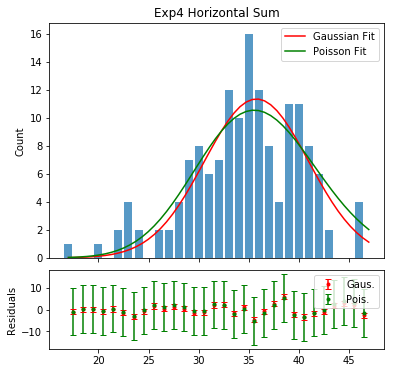

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Gaussian fit: a= 2.36 +/- 0.52 , x0= 1251.73 +/- 9.36 , sigma=sqrt(mu)= 36.35 +/- 10.82


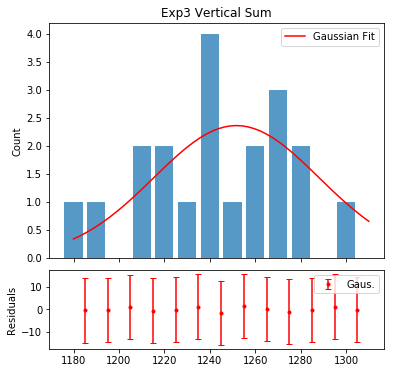

In [21]:
count = 0
for exp in cAllExp:
    binwidth=1
    bgdata = cBack5min['Background 5min.1']
    if (type(exp)== pd.core.frame.DataFrame and 'Exp3' in list(exp)[0]) or type(exp) == pd.core.series.Series:
        bgdata = cBack1min['Background 1min.1']
    
    if (type(exp) == pd.core.frame.DataFrame and 'Tech' in list(exp)[0]):
#         do all runs 3 times with different binwidths 1,2, (5?)
#         ADDDDDDD
        continue
        
    if type(exp) == pd.core.series.Series: # vertically added Exp3
        binwidth=10
        plotGauss, plotPoisson = True, False
        fittings = extract_and_plot_stuff('Exp3 Vertical Sum', bgdata, exp, binwidth, plotGauss, plotPoisson) 
        fitting_out[count].append(fittings)
        break
    for run in exp:
        plotGauss, plotPoisson = True, True
        if 'Sum' in run:
            bgdata = (exp.shape[1]-1)*bgdata #for summed we add num_run times? I guess? 
            if 'Exp2' in run and 'Sum':
                plotPoisson = False
        if 'Bonus 8.' in run : plotGauss, plotPoisson = False, True
        if 'Bonus 15.' in run : plotGauss, plotPoisson = False, False
        fittings = extract_and_plot_stuff(run, bgdata, exp[run], binwidth, plotGauss, plotPoisson)
        fitting_out[count].append(fittings)
    count+=1 

In [22]:
# RANDOM SCRAPS DELETE

#         bg_hist, bins = np.histogram(bgdata, bins=calcbins(exp[run], binwidth))
#         data_hist, _ = np.histogram(exp[run], bins=calcbins(exp[run], binwidth))
        
#         plot_hist = data_hist
#         for i in np.nonzero(bg_hist)[0]:
#             plot_hist[i] = plot_hist[i] - bg_hist[i] if data_hist[i] - bg_hist[i] > 0 else 0
        
# #         print(plot_hist, bins)
#         histx = [0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins)-1)]

#         data_mean_guess = exp[run].mean()
#         data_std_guess = exp[run].std()
#         data_a_guess = max(plot_hist)
#         guesses = [data_a_guess, data_mean_guess, data_std_guess]
        
#         plot_stuff(run, histx, plot_hist, guesses, bins, plotGauss, plotPoisson)

# ############# VERS 1
#         fig, (a0, a1) = plt.subplots(nrows=2, ncols=1, gridspec_kw = {'height_ratios':[3, 1]}, sharex=True, figsize=(6,6))
#         fig.subplots_adjust(hspace=.08)
#         a0.bar(bins[:-1], plot_hist, alpha=0.75)
#         xdata = np.linspace(min(bins), max(bins)) #for plotting g and p
        
#         if plotGauss == True:
#             gauss_params, gauss_cov = curve_fit(gauss_function,histx,plot_hist,p0=(data_a_guess,data_mean_guess,data_std_guess))
#             residuals_gauss = gauss_function(histx, *gauss_params) - plot_hist
#             print('Gaussian fit: a=', gauss_params[0], '+/-', errors(gauss_cov)[0] ,
#                   ', x0=', gauss_params[1], '+/-',  errors(gauss_cov)[1],
#                   ', sigma=sqrt(mu)=', gauss_params[2], '+/-',  errors(gauss_cov)[2])

#             a0.plot(xdata, gauss_function(xdata, *gauss_params), 'r', label='Gaussian Fit')

#             k_gauss = totalerr(gauss_cov)
#             a1.errorbar(histx, residuals_gauss, yerr = k_gauss, marker='.', color='r', linestyle='None', capsize=3, 
#                         label='Gaus.')
#         if plotPoisson == True:
#             poisson_params, poisson_cov = curve_fit(poisson_function, histx, plot_hist, p0=(data_a_guess, data_std_guess**2))
#             residuals_poisson = poisson_function(histx, *poisson_params) - plot_hist
#             print('Poisson fit: a=', poisson_params[0], '+/-', errors(poisson_cov)[0],
#                   ', mu=sigma^2=', poisson_params[1], '+/-', errors(poisson_cov)[1])

#             a0.plot(xdata, poisson_function(xdata, *poisson_params), 'g', label='Poisson Fit')
#             k_poisson = totalerr(poisson_cov)
#             a1.errorbar(histx, residuals_poisson, yerr=k_poisson, marker='.', color='g', linestyle='None', capsize=3, 
#                         label='Pois.')

#         a0.set_title(run)
#         a0.set_ylabel('Count')
#         a1.set_ylabel('Residuals')
#         a0.legend(); a1.legend()
#         plt.show()